## Animal Detection
### W281 Final Project
#### Sayyed Jilani, Mike Christenon, Richard Shim

### Introduction

[Here](https://www.kaggle.com/datasets/alessiocorrado99/animals10) is the link to the source data-set from Kaggle. and [here](www.google.com) is a link to the proposal.

The data set consists of about 28k images of animals belonging to 10 different categories including dog, cat, horse, spider, butterfly, chicken, sheep, cow and squirrel. While the majority of the data was collected from google images and verified with a human label check, there is some unknown amount of erroneous, mislabeled data added to simulate real-world conditions.

### Load and Filter
First we will load the raw dataframe of all images, display a few examples of each of the classes and then filter out rows that have been identified to have erroneous data (e.g. clearly mislabeled).

The sample of images highlight a few things about the images:
- they are not of the same scale
- quality of image itself varies
- the posiitioning of the animals vary
- some images only provide a partial view of the animal in question
- some images contain multiple animals in the frame
- some images contain noise in the form of text or logos

Manual inspection of images has shown instances of completely incorrect image or images containing multiple labels but only classified as one. These images will be removed.

In [ ]:
from preprocessing import *
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')
raw_file_df = load_raw_dataframe()
show_class_samples(raw_file_df)

In [ ]:
file_df = filter_mislabeled_images(raw_file_df)

## Down-Sample

In order to streamline the initial feature development process and avoid biasing towards over represented classes in the data set we chose to down-sample our data set so all classes have the same count as the minority class. Elephants are the minority class in the filtered data set with a total of 1431 rows.

In [ ]:
draw_class_counts(file_df, 'Raw Class Count Distribution')

In [ ]:
sample_df = down_sample(file_df)
draw_class_counts(sample_df, 'Downsampled Class Count Distribution')

# Feature Extraction (35 pts)

### Simple Feature 1 - Histogram of Gradients (HOG)

In [ ]:
def load_img_rgb(img_path, resize_dims=()):
    """Load the img with cv2 and convert color scheme to RGB"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if len(resize_dims) > 0:
        img = cv2.resize(img, resize_dims)
        img = img.astype('uint8')
    return img

def rgb_to_grayscale(img):
    """Transform the im"""
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype('float64') / 255.0
    return img

def hog_transform(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1,1), visualize=True):
    """perform histogram of gradients and return the result"""
    features, hog_img = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                     visualize=visualize)
    hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 1))
    return features, hog_img_rescaled


def show_hog_transform_examples(label_name, n_examples=5):
    """"""
    example_images = sample_df[sample_df.label_name == label_name].sample(n_examples, random_state=12345)['img_path'].to_list()
    fig, ax = plt.subplots(nrows=n_examples, ncols=3, figsize=(20, 20))
    for example in range(n_examples):
        example_img = load_img_rgb(example_images[example], resize_dims=(256, 256))
        example_img_grayscale = rgb_to_grayscale(example_img)
        hog_features, example_hog_img = hog_transform(example_img_grayscale)
        ax[example, 0].imshow(example_img)
        ax[example, 1].imshow(example_img_grayscale, cmap='gray')
        ax[example, 2].imshow(example_hog_img, cmap='gray')
        for axes in range(3):
            ax[example, axes].axis('off')
    fig.suptitle(f'{label_name.capitalize()} - HOG examples', fontsize=30)
    fig.tight_layout()
    plt.show()


show_hog_transform_examples("horse")
show_hog_transform_examples("spider")


In [ ]:
def hog_features(img_path, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1,1), visualize=False):
    """perform histogram of gradients and return the result"""
    img = load_img_rgb(img_path, resize_dims=(256, 256))
    img = rgb_to_grayscale(img)
    features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                     visualize=visualize)
    return features

# Only redo the calculation is the user doesn't have a local copy of the results already
if not os.path.isdir(FEATURE_PATH):
    os.mkdir(FEATURE_PATH)

t0 = timer()
if not os.path.isfile(f'{FEATURE_PATH}/hog_features.csv'):
    hog_feature_vector = np.array(list(map(hog_features, sample_df['img_path'])))
    np.savetxt(f'{FEATURE_PATH}/hog_features.csv', hog_feature_vector, delimiter=",")
    print(f'HOG feature vectors calculated in {timer() - t0} seconds')
else:
    hog_feature_vector = np.genfromtxt(f'{FEATURE_PATH}/hog_features.csv', delimiter=',')
    print(f'HOG feature vectors loaded in {timer() - t0} seconds')
print(hog_feature_vector.shape)

### Simple Feature 2 - HSV and RGB Color Histograms

In [ ]:
def plot_color_histogram_examples(df, example_label, n_examples=3):
    """"""
    image_samples = df[df['label_name'] == example_label]['img_path'].sample(n_examples, random_state=12345).to_list()
    fig, ax = plt.subplots(nrows=n_examples, ncols=3, figsize=(30, 20))
    for example in range(n_examples):
        rgb_img = load_img_rgb(image_samples[example])
        ax[example, 0].imshow(rgb_img)
        ax[example, 0].axis('off')

        # RGB histogram
        red_hist = cv2.calcHist([rgb_img], [0], None, [256], [0, 256])
        green_hist = cv2.calcHist([rgb_img], [1], None, [256], [0, 256])
        blue_hist = cv2.calcHist([rgb_img], [2], None, [256], [0, 256])
        ax[example, 1].plot(red_hist, color='red')
        ax[example, 1].plot(blue_hist, color='green')
        ax[example, 1].plot(green_hist, color='blue')
        ax[example, 1].set_title('RGB Histogram')

        # HSV histogram
        hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        h_hist = cv2.calcHist([hsv_img], [0], None, [180], [0, 180])
        s_hist = cv2.calcHist([hsv_img], [1], None, [256], [0, 256])
        v_hist = cv2.calcHist([hsv_img], [2], None, [256], [0, 256])

        ax[example, 2].plot(h_hist, color='black')
        ax[example, 2].plot(s_hist, color='magenta')
        ax[example, 2].plot(v_hist, color='brown')
        ax[example, 2].set_title('HSV Histogram')
    fig.suptitle(f'{example_label.capitalize()} - Color Histogram examples', fontsize=30)
    fig.tight_layout()
    plt.show()

plot_color_histogram_examples(sample_df, 'cow')


In [ ]:
from timeit import default_timer as timer

def color_features(df_row):
    rgb_img = load_img_rgb(df_row['img_path'])
    red_hist = cv2.calcHist([rgb_img], [0], None, [256], [0, 256])
    green_hist = cv2.calcHist([rgb_img], [1], None, [256], [0, 256])
    blue_hist = cv2.calcHist([rgb_img], [2], None, [256], [0, 256])
    df_row['red_mean'] = np.min([np.mean(red_hist), 255])
    df_row['green_mean'] = np.min([np.mean(green_hist), 255])
    df_row['blue_mean'] = np.min([np.mean(blue_hist), 255])

    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    h_hist = cv2.calcHist([hsv_img], [0], None, [180], [0, 180])
    s_hist = cv2.calcHist([hsv_img], [1], None, [256], [0, 256])
    v_hist = cv2.calcHist([hsv_img], [2], None, [256], [0, 256])
    df_row['h_mean'] = np.min([np.mean(h_hist), 180])
    df_row['s_mean'] = np.min([np.mean(s_hist), 255])
    df_row['v_mean'] = np.min([np.mean(v_hist), 255])
    return df_row


# Only redo the calculation is the user doesn't have a local copy of the results already
if not os.path.isdir(FEATURE_PATH):
    os.mkdir(FEATURE_PATH)

t0 = timer()
if not os.path.isfile(f'{FEATURE_PATH}/color_features.csv'):
    sample_df = sample_df.apply(color_features, axis=1)
    sample_df.to_csv(f'{FEATURE_PATH}/color_features.csv')
    print(f'Color features calculated in {timer() - t0}')
else:
    color_feature_vector = np.genfromtxt(f'{FEATURE_PATH}/color_features.csv', delimiter=',')
    print(f'Color feature vectors loaded in {timer() - t0} seconds')

In [ ]:
def plot_mean_color_histogram(df):
    """Plot a histogram of each each of the color statistics by color class """
    color_stat_cols = [['red_mean', 'green_mean', 'blue_mean'], ['h_mean', 's_mean', 'v_mean']]
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
    for row in range(len(color_stat_cols)):
        for col in range(len(color_stat_cols[row])):
            stat_name = color_stat_cols[row][col]
            sns.kdeplot(data=df, x=stat_name, hue='label_name', ax=ax[row, col], fill=False)
            ax[row, col].set_title(f'{stat_name} Histogram by Label')
            ax[row, col].set_xlabel(stat_name)
            ax[row, col].set_ylabel('count')
    plt.show()

sample_df = pd.read_csv(f'{FEATURE_PATH}/color_features.csv')
sample_df.head(10)
plot_mean_color_histogram(sample_df)

In [ ]:
def plot_mean_color_cdf(df):
    """Plot a histogram of each each of the color statistics by color class """
    color_stat_cols = [['red_mean', 'green_mean', 'blue_mean'], ['h_mean', 's_mean', 'v_mean']]
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
    for row in range(len(color_stat_cols)):
        for col in range(len(color_stat_cols[row])):
            stat_name = color_stat_cols[row][col]
            sns.ecdfplot(data=df, x=stat_name, hue='label_name', ax=ax[row, col])
            ax[row, col].set_title(f'{stat_name} CDF by Label')
            ax[row, col].set_xlabel(stat_name)
            ax[row, col].set_ylabel('count')
    plt.show()

sample_df = pd.read_csv(f'{FEATURE_PATH}/color_features.csv')
sample_df.head(10)
plot_mean_color_cdf(sample_df)

### Complex feature 1.1 - ResNet101 Final Layer

ResNet was trained on the ImageNet data set which is a very similar data set in nature to the Animals-10 sub-set. ResNet employs a Convolutional Neural Network architecture that progressively reduces the size of the input image with kernel convolution operations that learn kernel weights to extract meaningful information from different aspects of the image. By extracting the outputs of these CNN outputs at one or more stages of the ResNet sequence


In [41]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

def prepare_image(img_path):
    """"""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

def show_resnet_example_layers(label, df, feature_extractor, layer_numbers, n_samples=3):
    """Show some examples of what the ResNet101 feature embeddings look like for the given class label """
    example_img_paths = df[df['label_name'] == label].sample(n_samples, random_state=12345)['img_path'].to_list()
    fig, ax = plt.subplots(nrows=2+len(layer_numbers), ncols=n_samples, figsize=(15, 25))
    for example in range(len(example_img_paths)):
        img_path = example_img_paths[example]
        raw_img = load_img_rgb(img_path)
        prepared_img = prepare_image(img_path)
        resnet_layer_features = feature_extractor.predict(prepared_img)
        print(len(resnet_layer_features))

        ax[0, example].imshow(raw_img)
        ax[1, example].imshow(prepared_img[0], cmap='gray')

        if example == 0:
            ax[0, example].set_ylabel(f'Original', fontsize=20)
            ax[1, example].set_ylabel(f'Pre-processed', fontsize=20)

        if example == 1:
            ax[0, example].set_title(f'{label.capitalize()} ResNet101 Feature Examples', fontsize=30)

        for layer_index in range(len(layer_numbers)):
            layer_number = layer_numbers[layer_index]
            layer_features = resnet_layer_features[layer_number].squeeze()
            average_features = np.mean(layer_features, axis=-1)
            plot_ax = ax[2 + layer_index, example]
            plot_ax.imshow(average_features, cmap='gray', interpolation='nearest')
            if example == 0:
                plot_ax.set_ylabel(f'Layer {layer_number}', fontsize=20)


        for axes in [ax[0, example], ax[1, example]] + [ax[2 + layer_num, example]
                                                        for layer_num in range(len(layer_numbers))]:
            axes.set_xticks([])
            axes.set_yticks([])
            axes.set_xticklabels([])
            axes.set_yticklabels([])


    fig.tight_layout()
    plt.show()

# Load the base ResNet101 pre-trained model but leave the last classification layer off to keep in embedding space
resnet_model = ResNet101(weights='imagenet')
layer_outputs = [layer.output for layer in resnet_model.layers]
resnet_model = Model(inputs=resnet_model.input, outputs=layer_outputs)
print(resnet_model.summary())

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_18[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


347
1/1 [==============================] - 0s 88ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


347
1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


347


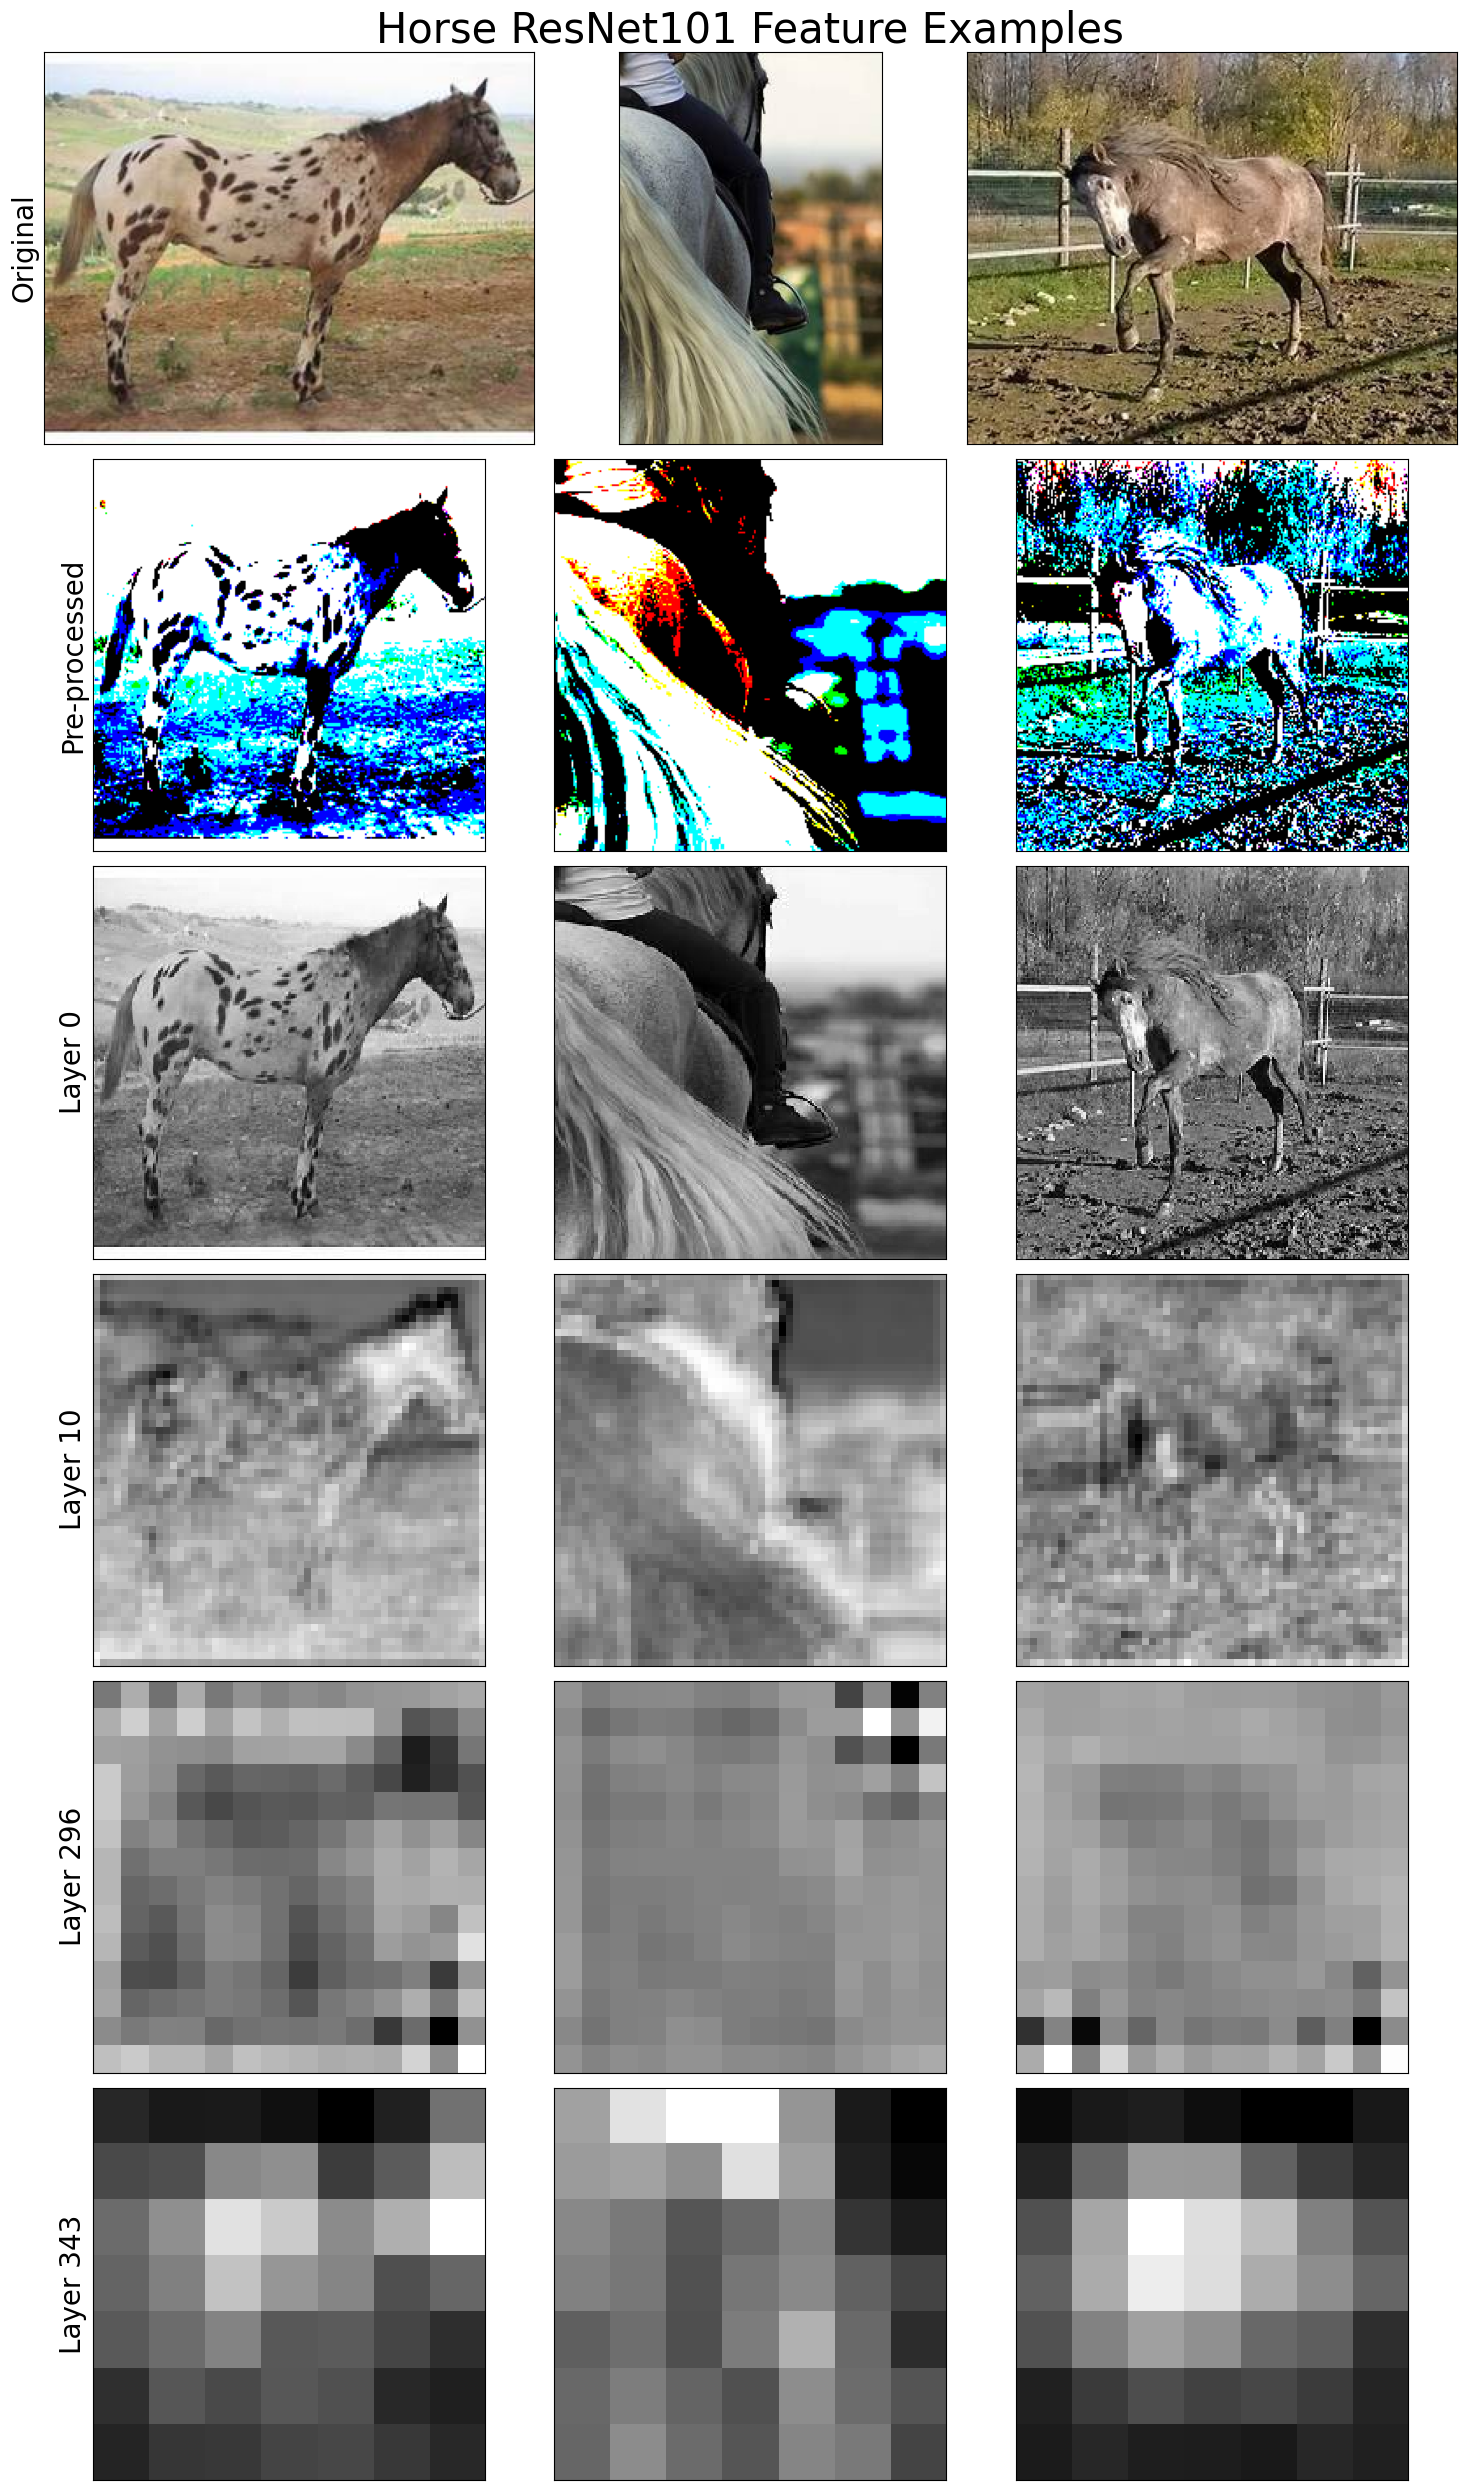

In [43]:
show_resnet_example_layers("horse", sample_df, resnet_model, layer_numbers=[0, 10, 296, 343])

In [44]:
# Actually perform the operation on the input image and save the results.
def load_and_preprocess_img(img_path):
    """"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = preprocess_input(img)
    return img


t0 = timer()
if not os.path.isfile(f'{FEATURE_PATH}/resnet101_features.npy'):
    base_resnet_model = ResNet101(weights='imagenet')
    resnet_model = Model(inputs=base_resnet_model.input, outputs=base_resnet_model.get_layer('avg_pool').output)
    img_paths = sample_df['img_path'].to_numpy()
    img_path_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
    img_dataset = img_path_dataset.map(load_and_preprocess_img)
    img_dataset = img_dataset.batch(32)
    resnet_feature_dataset = img_dataset.map(lambda x: resnet_model(x))
    all_features = [features.numpy() for features in resnet_feature_dataset]
    resnet_feature_array = np.vstack(all_features)
    np.save(f'{FEATURE_PATH}/resnet101_features.npy', resnet_feature_array)
    print(f"Resnet features for all images loaded and extracted in {timer() - t0:.2f}")
else:
    resnet_feature_array = np.load(f'{FEATURE_PATH}/resnet101_features.npy')
    print(f"Saved ResNet features loaded in {timer() - t0:.2f}")

2023-11-15 10:34:08.452611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-11-15 10:34:15.095086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-11-15 10:35:15.379980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-11-15 10:35:15.385532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-11-15 10:35:28.757178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-11-15 10:35:42.464477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-11-15 10:36:02.737038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-11-15 10:36:16.503914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-11-15 10:36:36.672649: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Resnet features for all images loaded and extracted in 2898.89


### PCA Decomposition

In [46]:
from sklearn.decomposition import PCA

# Raw Image Features


# HOG Features
hog_pca = PCA(n_components=0.95)
transformed_hog_features = hog_pca.fit(hog_feature_vector)
hog_explained_variation = hog_pca.explained_variance_ratio_.cumsum()

# Color Features


# Resnet Features
resnet_pca = PCA(n_components=0.95)
transformed_resnet_features = resnet_pca.fit(resnet_feature_array)
resnet_explained_variation = resnet_pca.explained_variance_ratio_.cumsum()


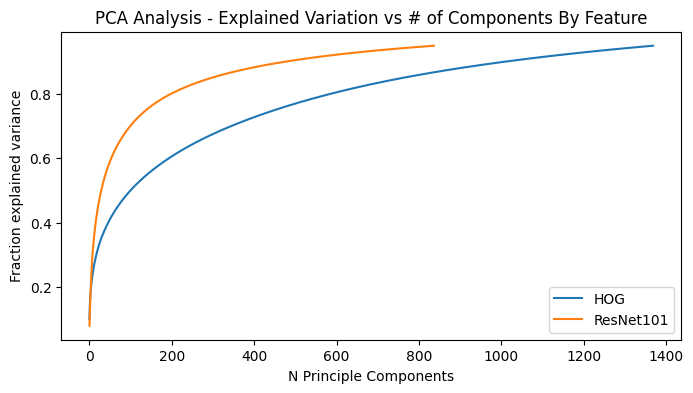

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
pca_features = [hog_explained_variation, resnet_explained_variation]
pca_labels = ['HOG', 'ResNet101']
for ii in range(len(pca_labels)):
    ax.plot(pca_features[ii], linestyle='-', label=pca_labels[ii])
    ax.set_xlabel('N Principle Components')
    ax.set_ylabel('Fraction explained variance')
    ax.set_title('PCA Analysis - Explained Variation vs # of Components By Feature')
ax.legend()
plt.show()

### tSNE Visualization

# Classification (35 pts)

In [ ]:
## Cross-fold validation function here 

### Classifier 1

Logisitic regression, SVM, simple perceptron.

### Classifier 2

Logisitic regression, SVM, simple perceptron.

# Results

### Generalization (10 pts)

Split data into train, val, and test groups before training classifier. Use hyper-parameter search to maximize ability to generalize. Discuss how each model did in terms of generalization.

### Efficiency vs Accuracy (10 pts)

For the various combination of three feature vectors and/or classifiers include characterization of accuracy vs computation time and optimize one solution for the best trade off. Include a discussion of trade-off.